In [ ]:
# Importing essential package

import io
import time
import json
import os
import re
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker.amazon.common as smac
from sagemaker import image_uris

from boto3 import client

from sklearn.model_selection import train_test_split

## Data Integration

In [2]:
role = sagemaker.get_execution_role() # Obtaining the AWS role 
region = boto3.Session().region_name  # Obtaining the AWS region

# S3 bucket for saving code and model artifacts.
bucket = "project-bucket-gaurav2"

prefix = (
    "input"  # place to upload training files within the bucket
)
print (region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
us-east-1


In [3]:
role 

'arn:aws:iam::277607018592:role/fast-ai-academic-36-Student-Azure'

In [5]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the file name and S3 bucket key
filename = 'train.csv'
bucket_name = 'project-bucket-gaurav2'
object_key = 'input/train.csv'

# Download the file
s3.download_file(bucket_name, object_key, filename)
df= pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Columns
Here's a brief version of what you'll find in the data description file.


SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.

MSSubClass: The building class

MSZoning: The general zoning classification

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access

Alley: Type of alley access

LotShape: General shape of property

LandContour: Flatness of the property

Utilities: Type of utilities available

LotConfig: Lot configuration

LandSlope: Slope of property

Neighborhood: Physical locations within Ames city limits

Condition1: Proximity to main road or railroad

Condition2: Proximity to main road or railroad (if a second is present)

BldgType: Type of dwelling

HouseStyle: Style of dwelling

OverallQual: Overall material and finish quality

OverallCond: Overall condition rating

YearBuilt: Original construction date

YearRemodAdd: Remodel date

RoofStyle: Type of roof

RoofMatl: Roof material

Exterior1st: Exterior covering on house

Exterior2nd: Exterior covering on house (if more than one material)

MasVnrType: Masonry veneer type

MasVnrArea: Masonry veneer area in square feet

ExterQual: Exterior material quality

ExterCond: Present condition of the material on the exterior

Foundation: Type of foundation

BsmtQual: Height of the basement

BsmtCond: General condition of the basement

BsmtExposure: Walkout or garden level basement walls

BsmtFinType1: Quality of basement finished area

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Quality of second finished area (if present)

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating

HeatingQC: Heating quality and condition

CentralAir: Central air conditioning

Electrical: Electrical system

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Number of bedrooms above basement level

Kitchen: Number of kitchens

KitchenQual: Kitchen quality

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality rating

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

GarageType: Garage location

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

GarageCond: Garage condition

PavedDrive: Paved driveway

WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality

Fence: Fence quality

MiscFeature: Miscellaneous feature not covered in other categories

MiscVal: $Value of miscellaneous feature

MoSold: Month Sold

YrSold: Year Sold

SaleType: Type of sale

SaleCondition: Condition of sale


## Data Analysis 

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# Finding out the total number of missing/ nan values in the dataset

df.isnull().sum().sort_values(ascending= False).head(50)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

We can observe there are a lot of Nan values in the dataset. Therefore I have created a new dataset by selecting only the most important features 

In [8]:
_df= df[['MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'YearBuilt', 'BedroomAbvGr', 'GarageType', 'SaleType', 'SaleCondition', 'SalePrice']]

In [9]:
_df

,MSSubClass,MSZoning,LotArea,LotConfig,YearBuilt,BedroomAbvGr,GarageType,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Inside,2003,3,Attchd,WD,Normal,208500
1,20,RL,9600,FR2,1976,3,Attchd,WD,Normal,181500
2,60,RL,11250,Inside,2001,3,Attchd,WD,Normal,223500
3,70,RL,9550,Corner,1915,3,Detchd,WD,Abnorml,140000
4,60,RL,14260,FR2,2000,4,Attchd,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Inside,1999,3,Attchd,WD,Normal,175000
1456,20,RL,13175,Inside,1978,3,Attchd,WD,Normal,210000
1457,70,RL,9042,Inside,1941,4,Attchd,WD,Normal,266500
1458,20,RL,9717,Inside,1950,2,Attchd,WD,Normal,142125


In [10]:
_df.isnull().sum()

MSSubClass        0
MSZoning          0
LotArea           0
LotConfig         0
YearBuilt         0
BedroomAbvGr      0
GarageType       81
SaleType          0
SaleCondition     0
SalePrice         0
dtype: int64

In [12]:
# Removing the nan values by filling them with random values.

_df['GarageType'].fillna(np.random.choice(_df['GarageType'].dropna()), inplace= True)

/tmp/ipykernel_18270/4244412269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['GarageType'].fillna(np.random.choice(_df['GarageType'].dropna()), inplace= True)


In [13]:
_df.isnull().sum()

MSSubClass       0
MSZoning         0
LotArea          0
LotConfig        0
YearBuilt        0
BedroomAbvGr     0
GarageType       0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

In [14]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotArea        1460 non-null   int64 
 3   LotConfig      1460 non-null   object
 4   YearBuilt      1460 non-null   int64 
 5   BedroomAbvGr   1460 non-null   int64 
 6   GarageType     1460 non-null   object
 7   SaleType       1460 non-null   object
 8   SaleCondition  1460 non-null   object
 9   SalePrice      1460 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 114.2+ KB


In [15]:
# Finding out the categorical and numerical columns

cate= []
num= []
for col in _df.columns:
    if (df[col].dtype == 'object'):
        cate.append(col)
    else:
        num.append(col)

print(f'Categorical Columns: {cate}')
print(f'Numerical Columns: {num}')

Categorical Columns: ['MSZoning', 'LotConfig', 'GarageType', 'SaleType', 'SaleCondition']
Numerical Columns: ['MSSubClass', 'LotArea', 'YearBuilt', 'BedroomAbvGr', 'SalePrice']


In [16]:
# Analysing each of the categorical columns

for col in cate:
    print(df[col].value_counts())
    print('-'*20)
    print()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
--------------------

LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
--------------------

GarageType
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
--------------------

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64
--------------------

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64
--------------------



## Data Visualization

In [17]:
cate

['MSZoning', 'LotConfig', 'GarageType', 'SaleType', 'SaleCondition']

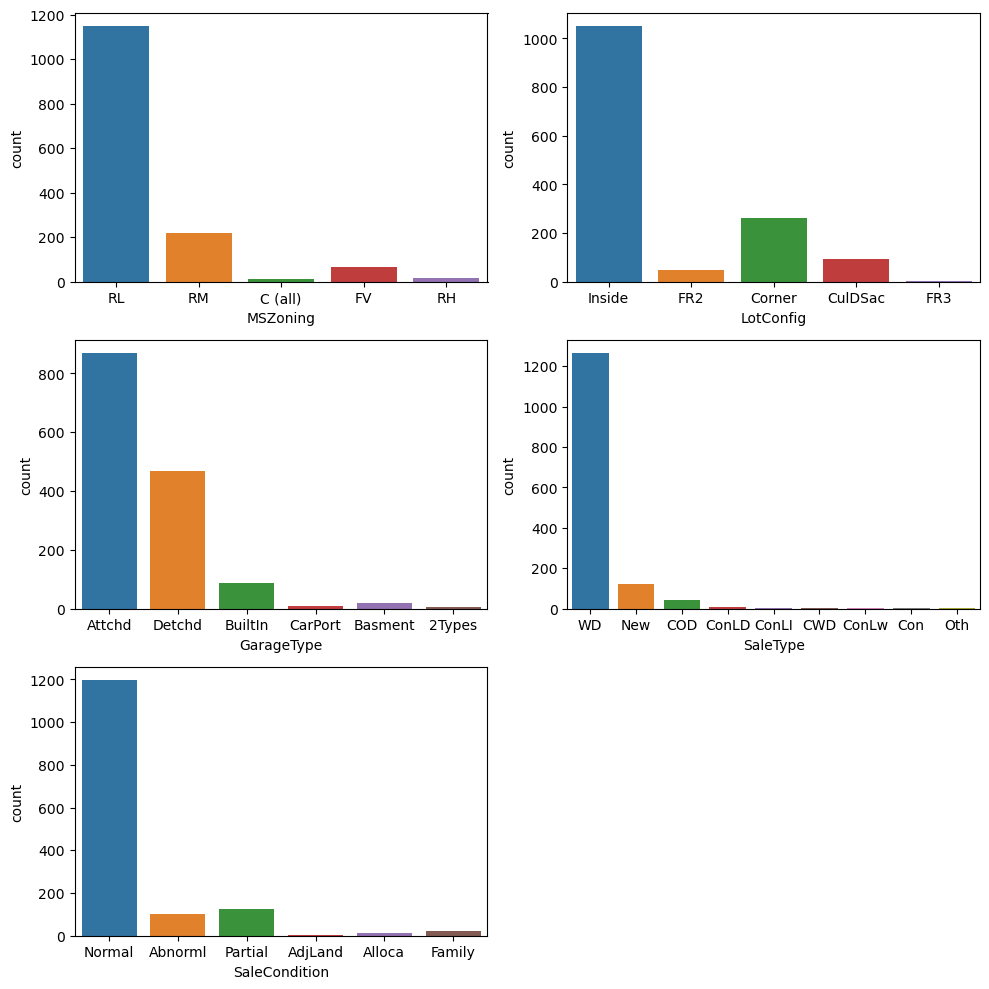

In [18]:
# Plotting the count plot for categorical features

fig = plt.figure(figsize=(10, 10))


plt.subplot(3,2,1)
sns.countplot(data= _df, x= 'MSZoning', hue= 'MSZoning')
plt.subplot(3,2,2)
sns.countplot(data= _df, x= 'LotConfig', hue= 'LotConfig')
plt.subplot(3,2,3)
sns.countplot(data= _df, x= 'GarageType', hue= 'GarageType')
plt.subplot(3,2,4)
sns.countplot(data= _df, x= 'SaleType', hue= 'SaleType')
plt.subplot(3,2,5)
sns.countplot(data= _df, x= 'SaleCondition', hue= 'SaleCondition')
fig.tight_layout()

In [19]:
_df.describe()

,MSSubClass,LotArea,YearBuilt,BedroomAbvGr,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,1971.267808,2.866438,180921.195890
std,42.300571,9981.264932,30.202904,0.815778,79442.502883
min,20.000000,1300.000000,1872.000000,0.000000,34900.000000
25%,20.000000,7553.500000,1954.000000,2.000000,129975.000000
50%,50.000000,9478.500000,1973.000000,3.000000,163000.000000
75%,70.000000,11601.500000,2000.000000,3.000000,214000.000000
max,190.000000,215245.000000,2010.000000,8.000000,755000.000000


In [20]:
num

['MSSubClass', 'LotArea', 'YearBuilt', 'BedroomAbvGr', 'SalePrice']

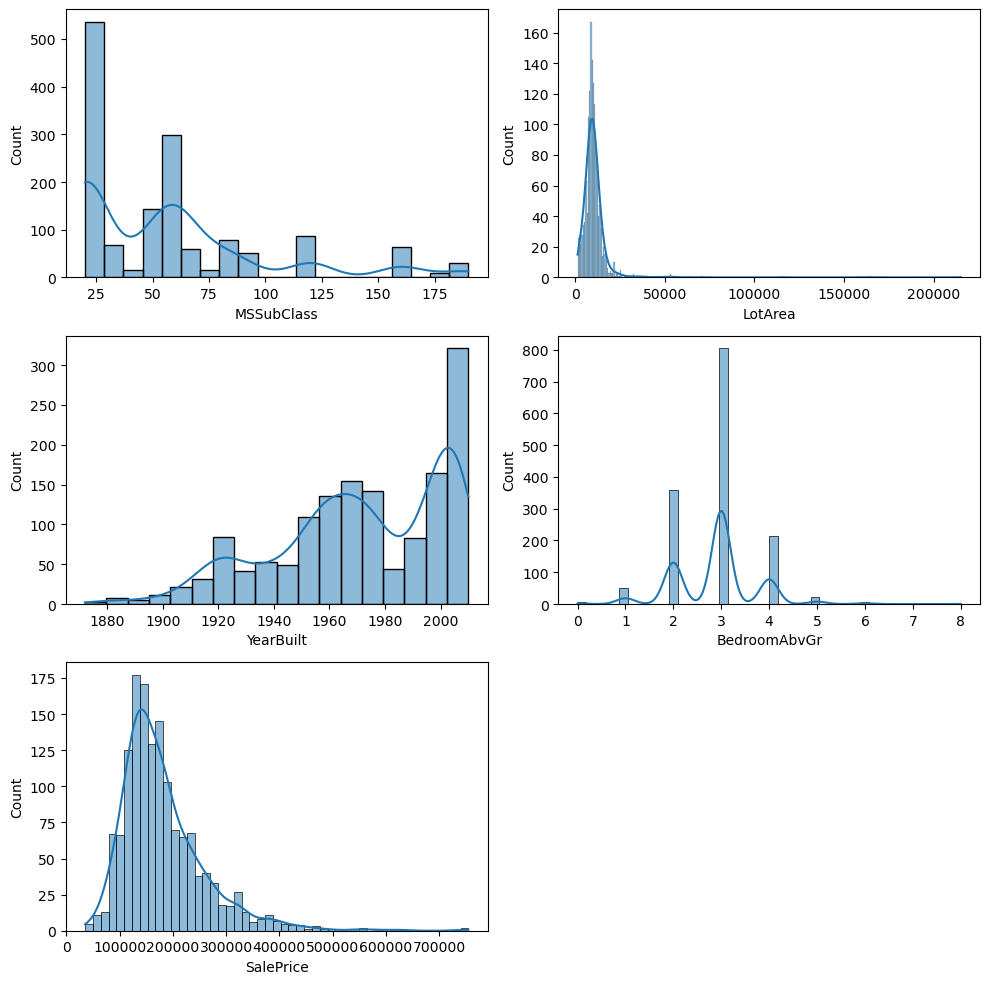

In [21]:
# Analysing the numerical features

fig = plt.figure(figsize=(10, 10))


plt.subplot(3,2,1)
sns.histplot(_df['MSSubClass'], kde= True)
plt.subplot(3,2,2)
sns.histplot(_df['LotArea'], kde= True)
plt.subplot(3,2,3)
sns.histplot(_df['YearBuilt'], kde= True)
plt.subplot(3,2,4)
sns.histplot(_df['BedroomAbvGr'], kde= True)
plt.subplot(3,2,5)
sns.histplot(_df['SalePrice'], kde= True)
fig.tight_layout()

We can observe that the numerical features are skewed. Thus applying log transformation to the columns can make datapoints normally distributed

In [22]:
# Log transformation of the numerical columns

for col in num:
    new_col= col+ '_log'
    _df[new_col]= np.log1p(df[col])

/tmp/ipykernel_18270/638923714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[new_col]= np.log1p(df[col])
/tmp/ipykernel_18270/638923714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[new_col]= np.log1p(df[col])
/tmp/ipykernel_18270/638923714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [23]:
_df.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'YearBuilt',
       'BedroomAbvGr', 'GarageType', 'SaleType', 'SaleCondition', 'SalePrice',
       'MSSubClass_log', 'LotArea_log', 'YearBuilt_log', 'BedroomAbvGr_log',
       'SalePrice_log'],
      dtype='object')

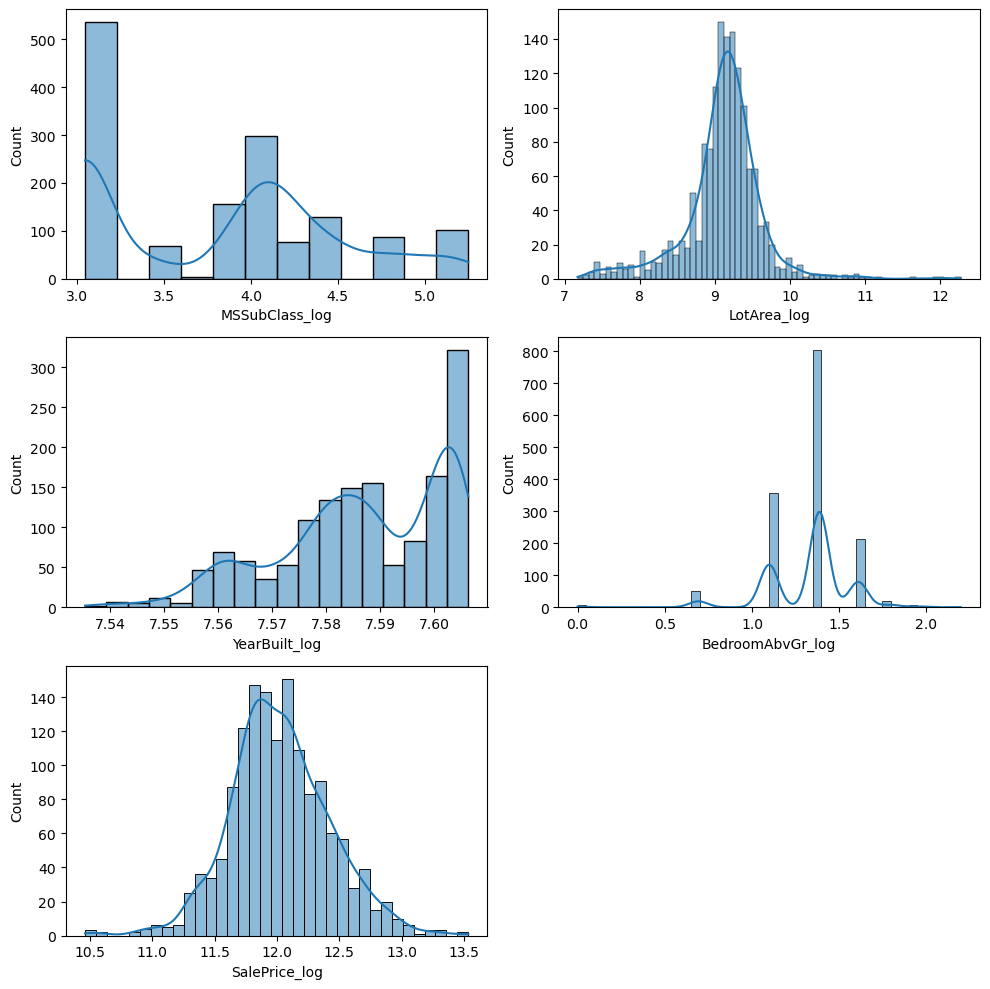

In [24]:
# Plot after the log transformation

fig = plt.figure(figsize=(10, 10))


plt.subplot(3,2,1)
sns.histplot(_df['MSSubClass_log'], kde= True)
plt.subplot(3,2,2)
sns.histplot(_df['LotArea_log'], kde= True)
plt.subplot(3,2,3)
sns.histplot(_df['YearBuilt_log'], kde= True)
plt.subplot(3,2,4)
sns.histplot(_df['BedroomAbvGr_log'], kde= True)
plt.subplot(3,2,5)
sns.histplot(_df['SalePrice_log'], kde= True)
fig.tight_layout()

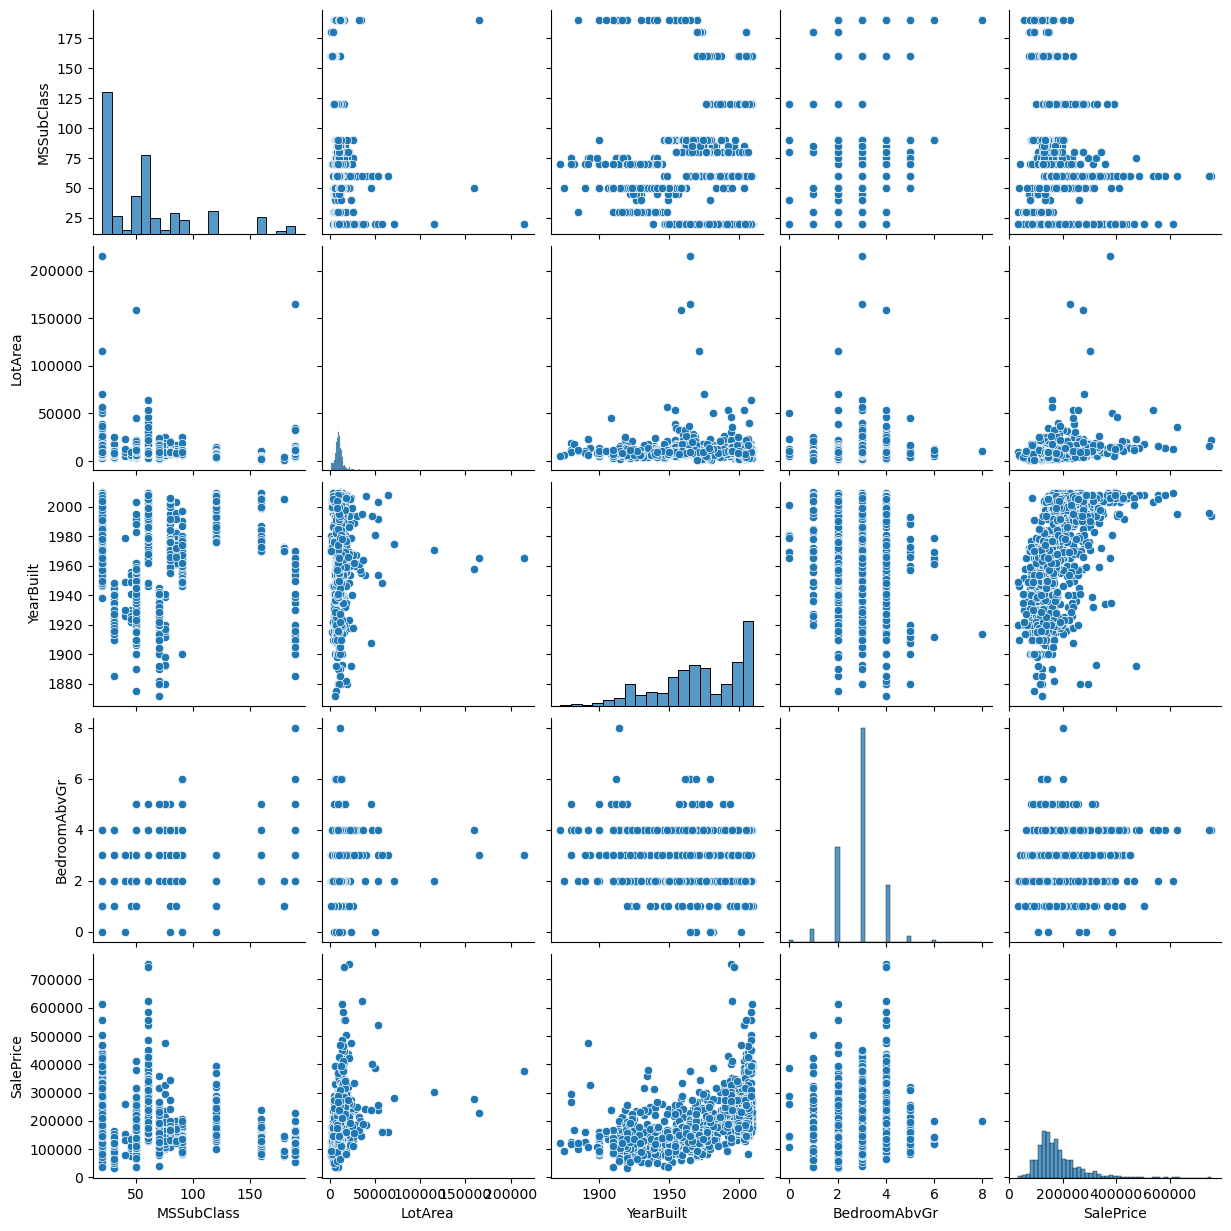

In [25]:
# Pairplot before transformation

sns.pairplot(_df[['MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 
                  'YearBuilt', 'BedroomAbvGr', 'GarageType', 
                  'SaleType', 'SaleCondition', 'SalePrice']])

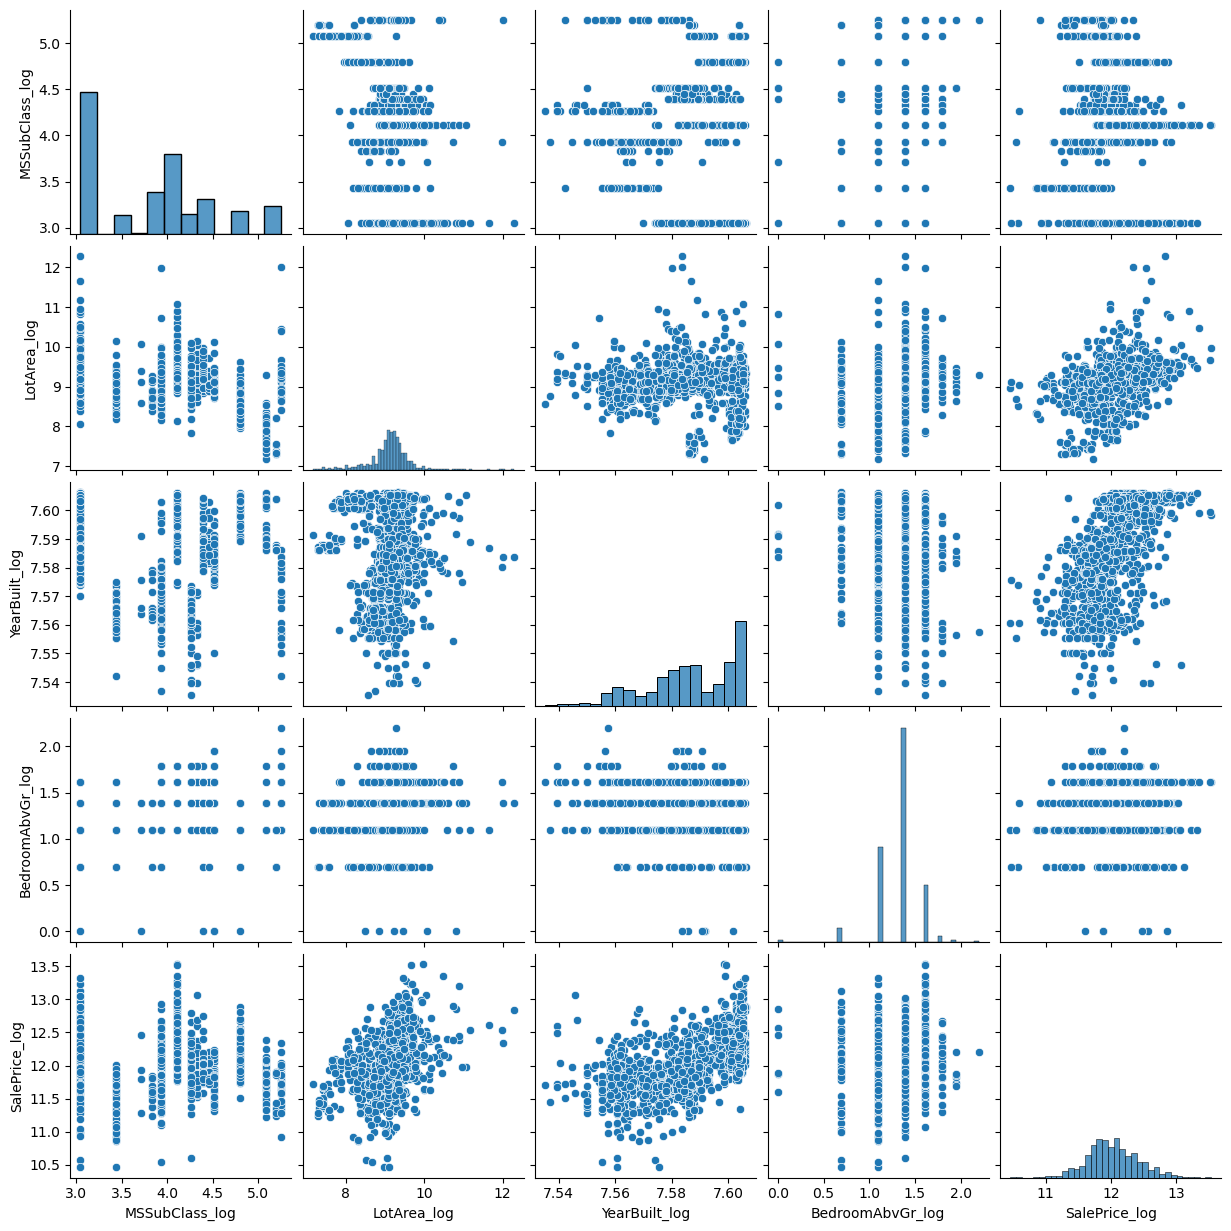

In [26]:
# Pairplot after the transformation

sns.pairplot(_df[['MSZoning','LotConfig',
       'GarageType', 'SaleType', 'SaleCondition',
       'MSSubClass_log', 'LotArea_log', 'YearBuilt_log',
       'BedroomAbvGr_log', 'SalePrice_log']])

<Axes: >

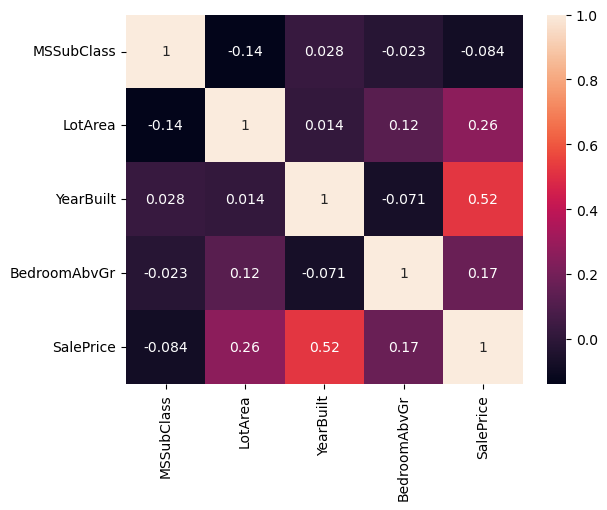

In [27]:
sns.heatmap(_df[num].corr(), annot= True)

In [28]:
num_log= []

for col in num:
    num_log.append(col+ '_log')
num_log

['MSSubClass_log',
 'LotArea_log',
 'YearBuilt_log',
 'BedroomAbvGr_log',
 'SalePrice_log']

<Axes: >

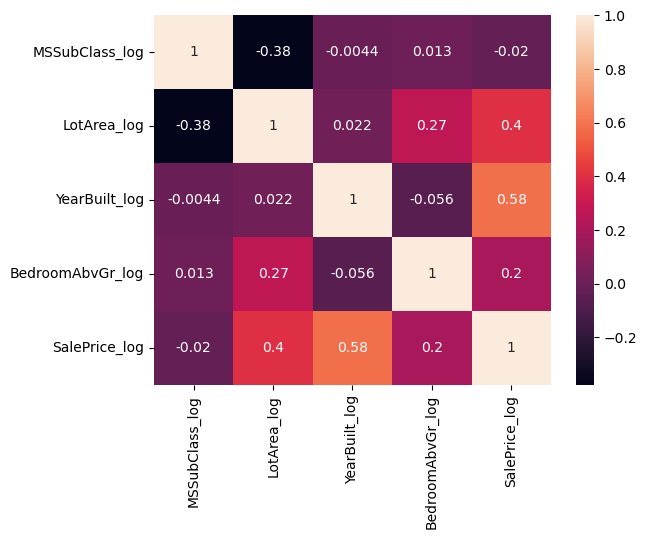

In [29]:
sns.heatmap(_df[num_log].corr(), annot= True)

In [30]:
_df.drop(df[num], axis= 1, inplace= True)

/tmp/ipykernel_18270/1679298748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.drop(df[num], axis= 1, inplace= True)


In [31]:
_df.head()

,MSZoning,LotConfig,GarageType,SaleType,SaleCondition,MSSubClass_log,LotArea_log,YearBuilt_log,BedroomAbvGr_log,SalePrice_log
0,RL,Inside,Attchd,WD,Normal,4.110874,9.042040,7.602900,1.386294,12.247699
1,RL,FR2,Attchd,WD,Normal,3.044522,9.169623,7.589336,1.386294,12.109016
2,RL,Inside,Attchd,WD,Normal,4.110874,9.328212,7.601902,1.386294,12.317171
3,RL,Corner,Detchd,WD,Abnorml,4.262680,9.164401,7.557995,1.386294,11.849405
4,RL,FR2,Attchd,WD,Normal,4.110874,9.565284,7.601402,1.609438,12.429220


In [32]:
# Encoding the categorical features

df_MSZoning= pd.get_dummies(df['MSZoning'], drop_first= True, dtype= int)
df_LotConfig =pd.get_dummies(df['LotConfig'], drop_first= True, dtype= int)
df_GarageType =pd.get_dummies(df['GarageType'], drop_first= True, dtype= int)
df_SaleType =pd.get_dummies(df['SaleType'], drop_first= True, dtype= int)
df_SaleCondition =pd.get_dummies(df['SaleCondition'], drop_first= True, dtype= int)

In [33]:
final_df= pd.concat([_df, df_MSZoning, df_LotConfig, df_GarageType, df_SaleType, df_SaleCondition], axis= 1)

In [34]:
final_df.drop(final_df[cate], axis= 1, inplace= True)

In [35]:
final_df.head()

,MSSubClass_log,LotArea_log,YearBuilt_log,BedroomAbvGr_log,SalePrice_log,FV,RH,RL,RM,CulDSac,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,4.110874,9.042040,7.602900,1.386294,12.247699,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3.044522,9.169623,7.589336,1.386294,12.109016,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,4.110874,9.328212,7.601902,1.386294,12.317171,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4.262680,9.164401,7.557995,1.386294,11.849405,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4.110874,9.565284,7.601402,1.609438,12.429220,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [36]:
X= final_df.drop(['SalePrice_log'], axis= 1)
y= final_df['SalePrice_log']

In [37]:
# Splitting the dataset into train, test and val

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_train.shape, X_val.shape, X_test.shape)

(1095, 30) (219, 30) (146, 30)


In [38]:
train_file = "linear_train.data" #sets the name of the file that will be created and eventually uploaded to Amazon S3

f = io.BytesIO() #creates an in-memory bytes buffer object. 
# This buffer (f) object can be used as a file object that you can read from and write to as if it were a reqular file.

# In the following line, we write the training data to the BytesIO buffer in a dense tensor format. 
# The train_X and train_y data are cast to the float32 type, 
smac.write_numpy_to_dense_tensor(f, X_train.to_numpy().astype("float32"), y_train.to_numpy().astype("float32"))
f.seek(0)  #reset the file's position to the beginning. 

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", train_file)
).upload_fileobj(f)

In [39]:
validation_file = "linear_validation.data"

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_val.to_numpy().astype("float32"), y_val.to_numpy().astype("float32"))
f.seek(0)

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation", validation_file)
).upload_fileobj(f)

## Model Training

In [40]:
#  Retrieve the Amazon SageMaker container image URI for the Linear Learner algorithm
container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

In [41]:
'''
This configuration can be used as input when creating a SageMaker training job, 
triggering the training process for the Linear Learner algorithm.
'''

linear_job = "PROJECT-linear-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) # creates an unique job name

print("Job name is:", linear_job)

# Dictionary with parameters for configuring the SageMaker Linear Learner training job
linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {"TrainingImage": container,   # Specifies the learning algorithm
                               "TrainingInputMode": "File"},  
    "ResourceConfig": {"InstanceCount": 1,                   # specifies computational resources of the training job
                       "InstanceType": "ml.c4.2xlarge",
                       "VolumeSizeInGB": 10}, 
    "InputDataConfig": [
        {
            "ChannelName": "train",
            
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "30",
        "mini_batch_size": "100",
        "predictor_type": "regressor",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Job name is: PROJECT-linear-2023-11-24-04-29-21


In [42]:
'''
This code block can be executed in a SageMaker environment to start training a Linear Learner model, 
monitor its progress, and handle potential failures.
'''

%%time  # magic cmd of jupyter notebook, used for printing the execution time

region = boto3.Session().region_name
sm = boto3.client("sagemaker")   # Creates a SageMaker client to interact with SageMaker service.

sm.create_training_job(**linear_training_params)  # Initiates the training job using the previously defined parameters.

status = sm.describe_training_job(TrainingJobName=linear_job)["TrainingJobStatus"]
print(status)
# sm.get_waiter Waits until the training job is completed or stopped.
sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=linear_job)  
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=linear_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress
CPU times: user 405 ms, sys: 18.5 ms, total: 424 ms
Wall time: 4min 1s


In [43]:
'''
After training a model using the Linear Learner algorithm, 
this code block can be used to create a SageMaker model for hosting the trained model. 
The model can then be deployed to a SageMaker endpoint for making predictions.
'''

linear_hosting_container = {  # dictionary specifying the container image and the location of the model artifacts in Amazon S3.
    "Image": container,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=linear_job)["ModelArtifacts"][
        "S3ModelArtifacts"  # Specifies the S3 location of the model artifacts
    ],
}

create_model_response = sm.create_model(  # Creates a SageMaker model for hosting using the provided configuration.
    ModelName=linear_job, ExecutionRoleArn=role, PrimaryContainer=linear_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:277607018592:model/project-linear-2023-11-24-04-29-21


In [44]:
'''
This code block creates an Amazon SageMaker endpoint configuration for deploying the Linear Learner model.
'''

linear_endpoint_config = "PROJECT-linear-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(linear_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(  # Creates an endpoint configuration using the provided parameters.
    EndpointConfigName=linear_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": linear_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

PROJECT-linear-endpoint-config-2023-11-24-04-33-22
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:277607018592:endpoint-config/project-linear-endpoint-config-2023-11-24-04-33-22


In [45]:
'''
This code block creates and deploys a SageMaker endpoint for hosting the trained Linear Learner model.
'''

%%time

linear_endpoint = "PROJECT-linear-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)
create_endpoint_response = sm.create_endpoint(  #  Initiates the creation of a SageMaker endpoint using the provided parameters.
    EndpointName=linear_endpoint, EndpointConfigName=linear_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=linear_endpoint)  # Retrieves information about the created endpoint.
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

PROJECT-linear-endpoint-202311240433
arn:aws:sagemaker:us-east-1:277607018592:endpoint/project-linear-endpoint-202311240433
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:277607018592:endpoint/project-linear-endpoint-202311240433
Status: InService
CPU times: user 64.5 ms, sys: 4.28 ms, total: 68.8 ms
Wall time: 4min 1s


In [46]:
def np2csv(arr):
    csv = io.BytesIO() #the function gets an array (Numpy array) and creates an in-memory binary buffer named csv
    np.savetxt(csv, arr, delimiter=",", fmt="%g") # write the array 'arr' to csv object, columns should be seperated by commas. The fmt="%g" removes unneccesary decimals when saving and use scientific notation.
    # In the following line:
    # csv.getvalue() retrieves the entire contents of the buffer csv as a byte string.
    # .decode() converts the byte string into a normal Python string by decoding it using the default UTF-8 encoding.
    #.rstrip() removes any trailing whitespace or newlines from the end of the string.
    return csv.getvalue().decode().rstrip()

In [47]:
'''
This code block performs inference using a trained Linear Learner model deployed on a SageMaker endpoint. 
It sends test data to the endpoint and processes the prediction results.
'''

runtime = boto3.client("runtime.sagemaker")  # Creates a SageMaker runtime client to interact with the SageMaker endpoint for inference.

payload = np2csv(X_test)  #  Converts the test data (X_test) to a CSV-formatted string using the np2csv function.

response = runtime.invoke_endpoint(  # Invokes the SageMaker endpoint for inference using the provided payload.
    EndpointName=linear_endpoint, ContentType="text/csv", Body=payload
)
result = json.loads(response["Body"].read().decode())  # Extracts and loads the prediction results from the response body, which is in JSON format.

test_pred = np.array([r["score"] for r in result["predictions"]])  # Extracts the prediction scores from the result dictionary. 

In [48]:
print (test_pred)

[11.9656868  12.10403442 12.23391342 12.36274338 11.58821487 12.13005829
 11.86649704 11.93404007 12.17940903 11.97032547 12.1657753  12.30101395
 11.81180954 12.17368698 11.9599762  11.99436951 11.97143936 11.46720886
 11.96424484 12.01818085 12.1952858  12.28642654 11.69718933 12.27537155
 12.02693939 12.40259552 12.05754089 11.68054199 11.9364357  12.16416931
 12.10385132 12.4335022  12.02645874 12.03595352 12.16329193 11.81706238
 11.96710968 12.24792099 11.68783188 11.65575027 11.87514114 12.32671356
 12.29666138 11.94736481 11.97032547 11.80370712 12.1750145  12.06162262
 11.92725372 12.02663803 11.79034424 12.14001846 12.10719681 11.85835648
 12.13593674 12.03013992 12.06562805 12.19742584 11.38005447 12.14544678
 11.73961258 11.63666534 11.98190308 12.64582062 11.79963684 12.25219727
 11.52625656 11.94389725 12.02465057 11.9420929  11.68714523 11.64964676
 12.14323807 11.49817657 12.23299026 11.73482895 12.13412857 11.89987183
 11.75511169 12.48395157 12.06400681 12.16708755 11

In [49]:
'''
This code block evaluates the performance of the trained Linear Learner model by calculating the
Mean Absolute Error (MAE) for both the model predictions and a baseline model.
'''

test_mae_linear = np.mean(np.abs(y_test - test_pred)) 
# Mean Absolute Error (MAE) of the predictions vs real target values.

# Calculate the MAE baseline model using a simple strategy:
# Always predict the median value of the target variable from the training dataset (np.median(train_y)). 
test_mae_baseline = np.mean(
    np.abs(y_test - np.median(y_train))
)  

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 0.302
Test MAE Linear: 0.202


In [50]:
sm.delete_endpoint(EndpointName=linear_endpoint)  # deletes the SageMaker endpoint

{'ResponseMetadata': {'RequestId': '7abfa06a-fecb-4954-8933-987717f7b95a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7abfa06a-fecb-4954-8933-987717f7b95a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 24 Nov 2023 04:37:24 GMT'},
  'RetryAttempts': 0}}

## Hyperparameter Tuning

In [51]:
'''
This code block sets up the configuration for a SageMaker Hyperparameter Tuning Job using the Linear Learner algorithm.
'''

# Hyperparameter tuning job name
linear_tuning_job_name = "PROJECT-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Tuning job name is:", linear_tuning_job_name)

# Hyperparameter tuning job configuration
linear_tuning_job_config = {
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
        "MetricName": "validation:absolute_loss",  # Use a valid metric for Linear Learner
        "Type": "Minimize",  # or "Maximize" based on your problem (Minimize for loss metrics, Maximize for accuracy, etc.)
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10,   # Specifies the maximum number of training jobs and parallel training jobs.
                       "MaxParallelTrainingJobs": 3},
    "ParameterRanges": {  # Specifies the hyperparameter ranges for tuning, including continuous and integer parameters.
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {"MaxValue": "1", "MinValue": "0.01", "Name": "learning_rate"},
        ],
        "IntegerParameterRanges": [
            {"MaxValue": "10", "MinValue": "1", "Name": "mini_batch_size"},
        ],
    },
}

linear_tuning_job_definition = {  # Specifies the training job definition for the Hyperparameter Tuning Job.
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "RoleArn": role,
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.c4.2xlarge", "VolumeSizeInGB": 10},
    "StaticHyperParameters": {
        "feature_dim": "30",
        "predictor_type": "regressor",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Tuning job name is: PROJECT-2023-11-24-04-37-25


In [52]:
'''
This code block creates a SageMaker Hyperparameter Tuning Job using the specified configuration.
'''

smclient = boto3.Session().client("sagemaker")  # Creates a SageMaker client to interact with SageMaker services.

smclient.create_hyper_parameter_tuning_job(  # Initiates the creation of a Hyperparameter Tuning Job using the provided parameters.
    HyperParameterTuningJobName=linear_tuning_job_name,
    HyperParameterTuningJobConfig=linear_tuning_job_config,
    TrainingJobDefinition=linear_tuning_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:277607018592:hyper-parameter-tuning-job/PROJECT-2023-11-24-04-37-25',
 'ResponseMetadata': {'RequestId': '4c93d639-5730-4004-8b70-bd84e0bf85cf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4c93d639-5730-4004-8b70-bd84e0bf85cf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '128',
   'date': 'Fri, 24 Nov 2023 04:37:25 GMT'},
  'RetryAttempts': 0}}

In [53]:
# This code line retrieves the current status of a SageMaker Hyperparameter Tuning Job.

smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=linear_tuning_job_name)[
    "HyperParameterTuningJobStatus"
]

'InProgress'

In [54]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=linear_tuning_job_name)['HyperParameterTuningJobName']

'PROJECT-2023-11-24-04-37-25'

In [59]:
'''
This code block checks the current status and results of a completed or ongoing SageMaker Hyperparameter Tuning Job.
'''

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=linear_tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

10 training jobs have completed


In [60]:
'''
This code block checks if any training jobs in the Hyperparameter Tuning Job have reported results and 
displays information about the best-performing model.
'''

from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 24, 4, 43, 2, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:absolute_loss',
                                                 'Value': 0.18260765075683594},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 24, 4, 43, 37, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:277607018592:training-job/PROJECT-2023-11-24-04-37-25-010-4106e1a4',
 'TrainingJobName': 'PROJECT-2023-11-24-04-37-25-010-4106e1a4',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 24, 4, 43, 5, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.010105854209200101',
                          'mini_batch_size': '7'}}


In [61]:
'''
This code block utilizes SageMaker HyperparameterTuningJobAnalytics to analyze and 
display results from a Hyperparameter Tuning Job.
'''

tuner = sagemaker.HyperparameterTuningJobAnalytics(linear_tuning_job_name)
# Creates a HyperparameterTuningJobAnalytics object for the specified tuning job.

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

full_df

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Number of training jobs with valid objective: 10
{'lowest': 0.18260765075683594, 'highest': 0.3378874957561493}


,learning_rate,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.010106,7.0,PROJECT-2023-11-24-04-37-25-010-4106e1a4,Completed,0.182608,2023-11-24 04:43:05+00:00,2023-11-24 04:43:37+00:00,32.0
1,1.000000,1.0,PROJECT-2023-11-24-04-37-25-009-2b7f277a,Completed,0.337887,2023-11-24 04:43:03+00:00,2023-11-24 04:43:55+00:00,52.0
2,0.121648,7.0,PROJECT-2023-11-24-04-37-25-008-71d924bb,Completed,0.196768,2023-11-24 04:42:15+00:00,2023-11-24 04:42:47+00:00,32.0
3,1.000000,2.0,PROJECT-2023-11-24-04-37-25-007-9282e366,Completed,0.189233,2023-11-24 04:42:08+00:00,2023-11-24 04:42:50+00:00,42.0
4,0.010041,1.0,PROJECT-2023-11-24-04-37-25-006-06ba3019,Completed,0.189620,2023-11-24 04:42:15+00:00,2023-11-24 04:42:57+00:00,42.0
5,0.174785,6.0,PROJECT-2023-11-24-04-37-25-005-7d0dccf4,Completed,0.201579,2023-11-24 04:41:26+00:00,2023-11-24 04:41:58+00:00,32.0
6,0.013230,7.0,PROJECT-2023-11-24-04-37-25-004-a8fdd01d,Completed,0.188097,2023-11-24 04:41:24+00:00,2023-11-24 04:41:56+00:00,32.0
7,0.733233,2.0,PROJECT-2023-11-24-04-37-25-003-188a58b8,Completed,0.190181,2023-11-24 04:39:22+00:00,2023-11-24 04:41:30+00:00,128.0
8,0.398590,4.0,PROJECT-2023-11-24-04-37-25-002-584e4c18,Completed,0.202072,2023-11-24 04:39:14+00:00,2023-11-24 04:41:16+00:00,122.0
9,0.173964,10.0,PROJECT-2023-11-24-04-37-25-001-0a51e1ea,Completed,0.257228,2023-11-24 04:39:17+00:00,2023-11-24 04:41:14+00:00,117.0
